## Data Cleaning and EDA for Hotel Booking Dataset

### Imports and Data Loading

#### Imports

In [10]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from pyspark.sql import SparkSession

#### Spark Initialization

In [4]:
# remove any old spark vars remaining
os.environ.pop("SPARK_MASTER", None)
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local[*] pyspark-shell"

# stop spark sessions remaining
try:
    from pyspark.sql import SparkSession
    spark = SparkSession.getActiveSession()
    if spark is not None:
        spark.stop()
except Exception as e:
    print("No active Spark session found.")

In [ ]:
# new spark session that runs locally
spark = (
    SparkSession.builder
    .appName("HotelBookingDataCleaning")
    .master("local[*]")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .getOrCreate()
)

#### Data Reading and Schema Viewing

In [6]:
hotel_booking = spark.read.csv('datasets/hotel-booking.csv', header=True, inferSchema=True)

In [ ]:
hotel_booking.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- country: string (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- email: string (nullable = true)



### Cleaning

Before we continue with the EDA it is important to clean out any NaN's or null values from the data.

### EDA

In the EDA for the hotel_booking dataset, we're trying to see how many rows and columns the csv file has along with the summary statistics and distribution for each column (individually). There are 13 columns and 78703 rows.

For categorical variables, we're interested in seeing how many categories there are and the frequency of each. This will be done with a frequency table and a bar chart.

For numerical variables, we're interested in seeing the distribution. This will be done by plotting a histogram and printing some summary statistics.

At a first glance, there are some columns that seem to mesh together because they record similar events.
1. Arrival year, month, day, and week number
2. stays_in_week_nights and stays_in_weekend_nights

In [16]:
hotel_pd = hotel_booking.toPandas()

In [61]:
hotel_pd_shape = hotel_pd.shape

print(f"Number of Rows: {hotel_pd_shape[0]}")
print(f"Number of Columns: {hotel_pd_shape[1]}")

Number of Rows: 78703
Number of Columns: 13


#### Hotel Column

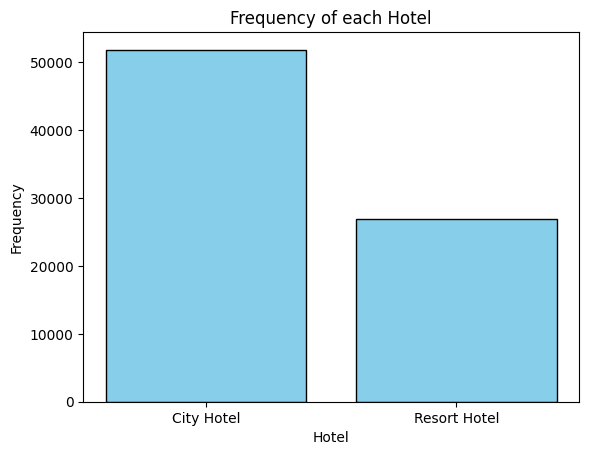

Frequencies of each hotel:
          hotel  count
0    City Hotel  51822
1  Resort Hotel  26881


In [32]:
# frequency for hotel column
hotel_counts = hotel_pd["hotel"].value_counts().reset_index()

# bar chart
plt.bar(hotel_counts["hotel"], hotel_counts["count"], color="skyblue", edgecolor="black")
plt.xlabel("Hotel")
plt.ylabel("Frequency")
plt.title("Frequency of each Hotel")
plt.show()

# frequency table
print("Frequencies of each hotel:")
print(hotel_counts)

The City Hotel received a lot more bookings (≈52,000) than the Resort Hotel (≈27,000).

#### Booking Status Column

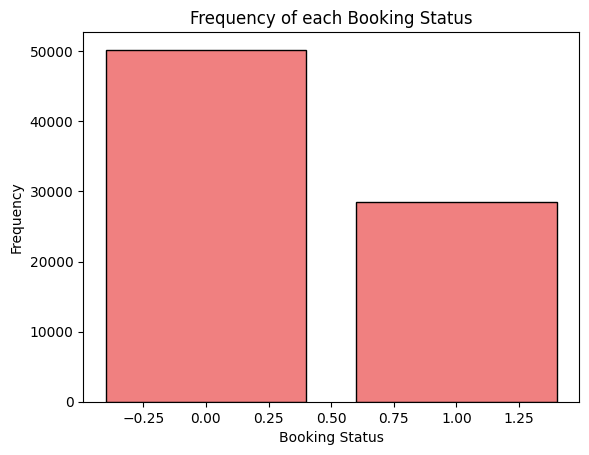

Frequencies of Booking Status:
   booking_status  count
0               0  50224
1               1  28479


In [38]:
# frequency for booking status column
booking_status_counts = hotel_pd["booking_status"].value_counts().reset_index()

# bar chart
plt.bar(booking_status_counts["booking_status"], booking_status_counts["count"], color="lightcoral", edgecolor="black")
plt.xlabel("Booking Status")
plt.ylabel("Frequency")
plt.title("Frequency of each Booking Status")
plt.show()

# frequency table
print("Frequencies of Booking Status:")
print(booking_status_counts)

There were more bookings with status 0 (≈50,000) than 1 (≈29,000), indicating that a larger share of bookings were not completed or canceled, while fewer were successful or confirmed.

#### Lead Time Column

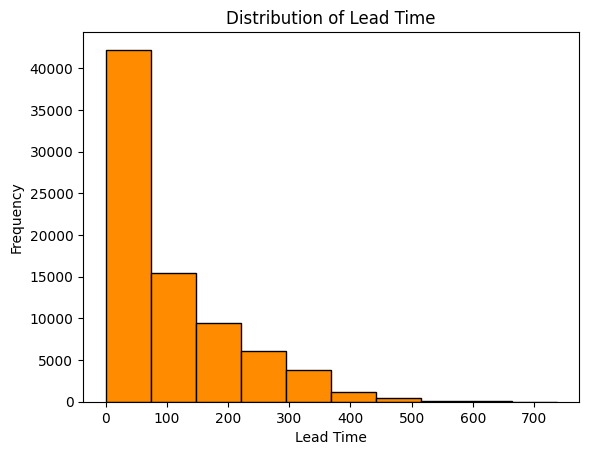

In [39]:
plt.hist(hotel_pd["lead_time"], bins=10, color="darkorange", edgecolor="black")
plt.xlabel("Lead Time")
plt.ylabel("Frequency")
plt.title("Distribution of Lead Time")

plt.show()

In [43]:
hotel_pd["lead_time"].describe()

count    78703.000000
mean       101.298464
std        106.200649
min          0.000000
25%         16.000000
50%         65.000000
75%        158.000000
max        737.000000
Name: lead_time, dtype: float64

The lead time column is numerical and skewed to the right. This is seen in both the histogram of the column's values and in its summary statistics (mean is greater than median with the maximum being far from the 3rd quartile).

#### Arrival Date Columns

In [ ]:
# frequency by year and month
arrival_date_counts = hotel_pd.groupby(["arrival_year", "arrival_month"]).size().reset_index(name="count")
# sort by frequency
arrival_date_counts = arrival_date_counts.sort_values(by="count", ascending=False)

arrival_date_counts

,arrival_year,arrival_month,count
16,2016,October,6203
14,2016,May,5478
6,2016,April,5428
17,2016,September,5394
12,2016,June,5292
5,2015,September,5114
7,2016,August,5063
4,2015,October,4957
13,2016,March,4824
11,2016,July,4572


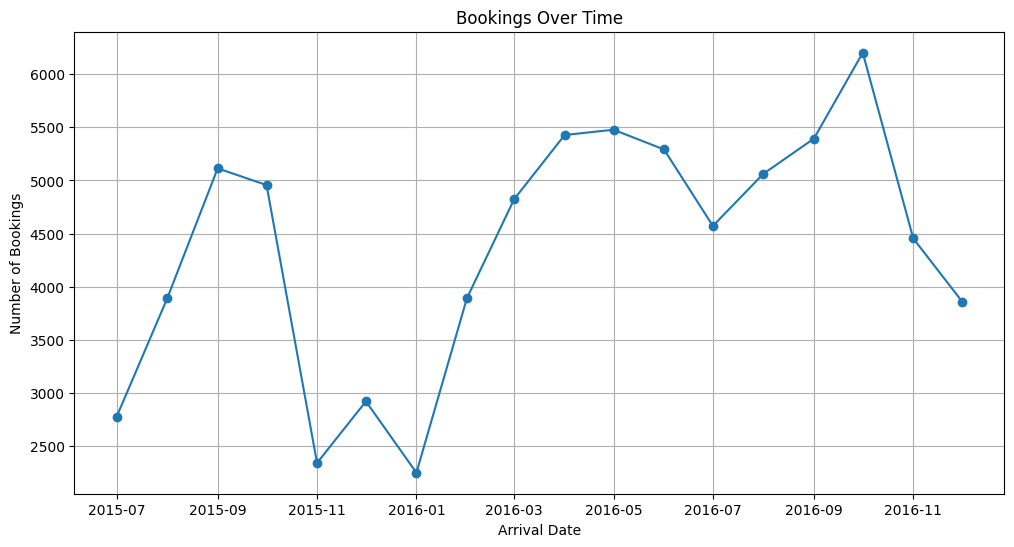

In [ ]:
# Date time column
arrival_date_counts["arrival_date"] = pd.to_datetime(
    arrival_date_counts["arrival_year"].astype(str) + "-" +
    arrival_date_counts["arrival_month"].astype(str) + "-01"
)

# Sort by datetime
arrival_date_counts = arrival_date_counts.sort_values("arrival_date")

# plot
plt.figure(figsize=(12,6))
plt.plot(arrival_date_counts["arrival_date"], arrival_date_counts["count"], marker='o')
plt.xlabel("Arrival Date")
plt.ylabel("Number of Bookings")
plt.title("Bookings Over Time")
plt.grid(True)
plt.show()

At first glance, the number of bookings per month over time looking sporadic. The most noticable features are a sharp increase in bookings from 07/2015 to 09/2015 and a sharp decline and increase from 10/2015 to 03/2016.

#### Weekday and Weekend Staying Columns

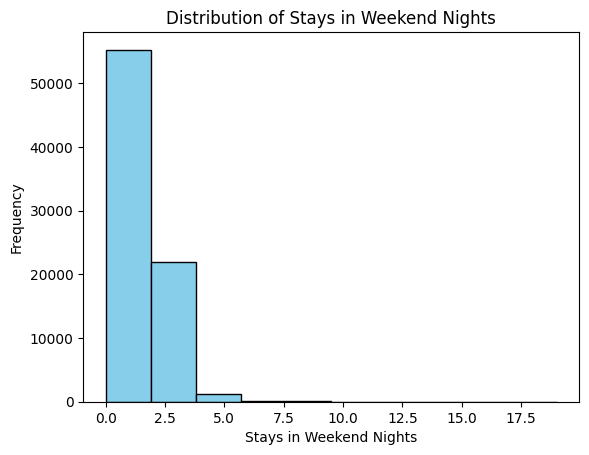

In [59]:
plt.hist(hotel_pd["stays_in_weekend_nights"], color="skyblue", edgecolor="black")
plt.xlabel("Stays in Weekend Nights")
plt.ylabel("Frequency")
plt.title("Distribution of Stays in Weekend Nights")

plt.show()

In [62]:
hotel_pd["stays_in_weekend_nights"].describe()

count    78703.000000
mean         0.903968
std          0.989566
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: stays_in_weekend_nights, dtype: float64

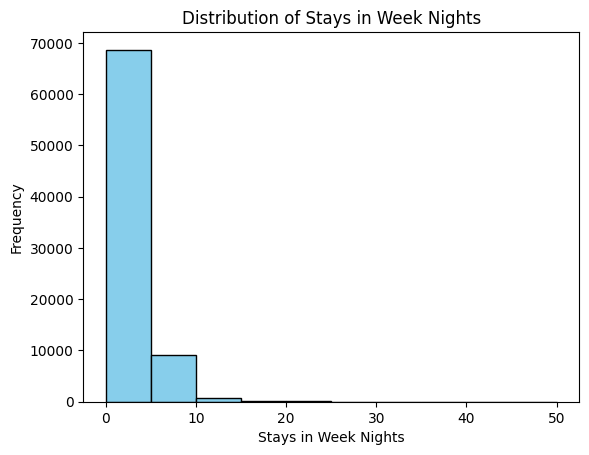

In [60]:
plt.hist(hotel_pd["stays_in_week_nights"], color="skyblue", edgecolor="black")
plt.xlabel("Stays in Week Nights")
plt.ylabel("Frequency")
plt.title("Distribution of Stays in Week Nights")

plt.show()

In [64]:
hotel_pd["stays_in_week_nights"].describe()

count    78703.000000
mean         2.447963
std          1.871663
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         50.000000
Name: stays_in_week_nights, dtype: float64

Both columns recording days stays are skewed to the right. The majority of hotel bookings are for a short period of time(~2 days) with some very high data points (>10 days) skewing the data.

#### Market Segment Type Column

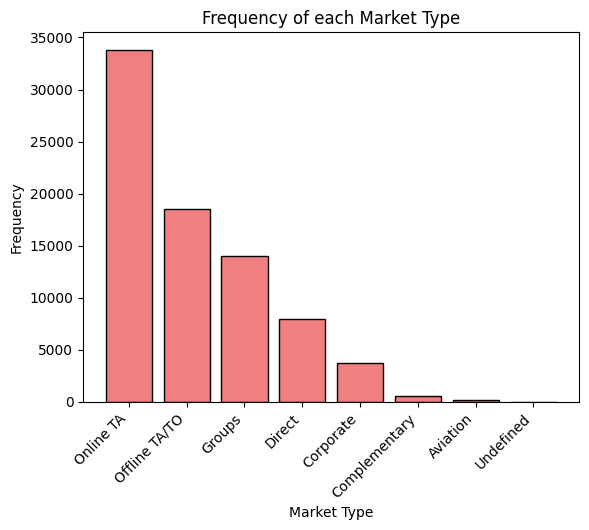

Frequencies of Market Type:
  market_segment_type  count
0           Online TA  33826
1       Offline TA/TO  18552
2              Groups  13957
3              Direct   7977
4           Corporate   3733
5       Complementary    529
6            Aviation    127
7           Undefined      2


In [67]:
# frequency for market column
market_counts = hotel_pd["market_segment_type"].value_counts().reset_index()

# bar chart
plt.bar(market_counts["market_segment_type"], market_counts["count"], color="lightcoral", edgecolor="black")
plt.xlabel("Market Type")
plt.ylabel("Frequency")
plt.title("Frequency of each Market Type")
plt.xticks(rotation=45, ha="right")
plt.show()

# frequency table
print("Frequencies of Market Type:")
print(market_counts)

Looking at the frequency of each market type, we can see that "Online TA" takes up a huge portion of the data. Offline TA/TO and Groups follows behind. Direct and Corporate take up a meager portion of the data points. Complemntary, Aviation, and Undefined barely make up the datapoints.

#### Country Column

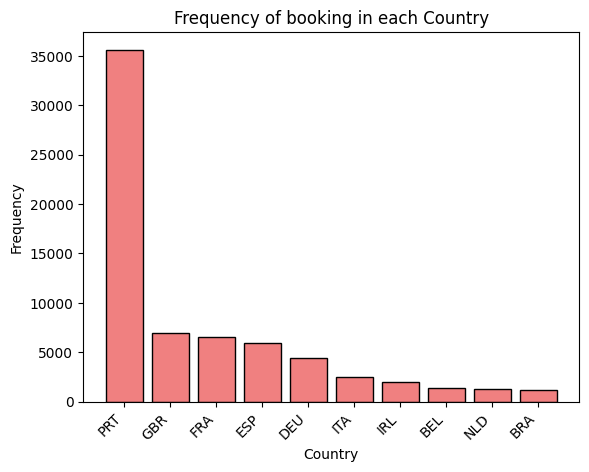

Frequencies of booking in each Country:
  country  count
0     PRT  35628
1     GBR   6941
2     FRA   6513
3     ESP   5956
4     DEU   4389
5     ITA   2453
6     IRL   1972
7     BEL   1344
8     NLD   1300
9     BRA   1214


In [47]:
# frequency for market column
country_counts = hotel_pd["country"].value_counts().head(10).reset_index()

# bar chart
plt.bar(country_counts["country"], country_counts["count"], color="lightcoral", edgecolor="black")
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.title("Frequency of booking in each Country")
plt.xticks(rotation=45, ha="right")
plt.show()

# frequency table
print("Frequencies of booking in each Country:")
print(country_counts)

Looking at the top 10 countries our data is coming from, we can see that PRT (Portugal) takes up a huge portion of the data points. With GBR, FRA, ESP, and DEU tailing behind each with frequencies from 4k to 7k. The remaining 5 countries in the top 5 all have frequencies around 1k-2k.

#### Average Price Column

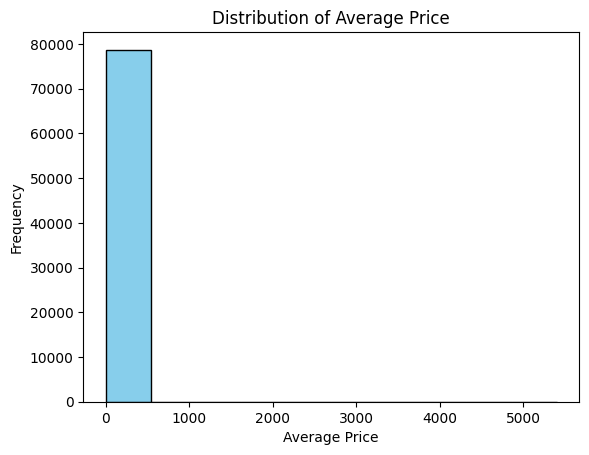

In [26]:
plt.hist(hotel_pd["avg_price_per_room"], bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Average Price")
plt.ylabel("Frequency")
plt.title("Distribution of Average Price")

plt.show()

In [45]:
hotel_pd["avg_price_per_room"].describe()

count    78703.000000
mean        95.210390
std         48.309882
min          0.000000
25%         65.000000
50%         89.000000
75%        117.300000
max       5400.000000
Name: avg_price_per_room, dtype: float64

Most of the data points have average price somewhere below 1k. We can't really view the distribution of this bar because of some really high outliers. To proceed, we're going to only plot points that are not outliers (IQR) to view the distribution of the majority of points.

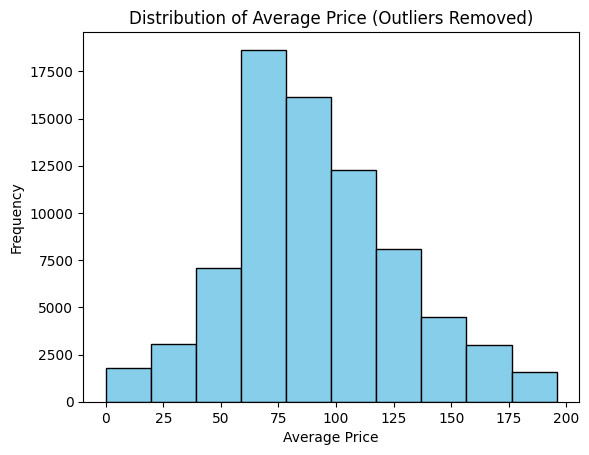

In [65]:
# bounds to deal with outliers
q1 = hotel_pd["avg_price_per_room"].quantile(0.25)
q3 = hotel_pd["avg_price_per_room"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# filtering outliers
filtered_prices = hotel_pd[
    (hotel_pd["avg_price_per_room"] >= lower_bound) &
    (hotel_pd["avg_price_per_room"] <= upper_bound)
]["avg_price_per_room"]

# plot
plt.hist(filtered_prices, bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Average Price")
plt.ylabel("Frequency")
plt.title("Distribution of Average Price (Outliers Removed)")
plt.show()

In [66]:
filtered_prices.describe()

count    76192.000000
mean        90.753881
std         37.500594
min          0.000000
25%         65.000000
50%         87.300000
75%        114.300000
max        195.750000
Name: avg_price_per_room, dtype: float64

Comparing the counts of the unfiltered and filtered data, we can see that there are around ~2k data points with very high prices. After removing these outliers, we see that the majority of the average price data is between 0 and 200. The histogram slightly resembles a normal distribution.

### EDA Findings and Conclusion

The dataset contains **78,703** rows and **13** columns.

Each column was analyzed individually to understand its distribution and frequency.

- Categorical variables were explored using frequency tables and bar charts to show the number of categories and their frequencies.
- Numerical variables were examined using histograms and summary statistics to show their distributions and central tendencies.

**Key Observations:**

**1. Hotel Type:**
The City Hotel received significantly more bookings (≈52,000) than the Resort Hotel (≈27,000).

**2. Booking Status:**
There were more bookings with status 0 (≈50,000) than 1 (≈29,000), indicating a larger share of bookings were not completed or canceled.

**3. Lead Time:**
The lead_time variable is right-skewed. The mean is greater than the median, and the maximum value is far above the third quartile.

**4. Arrival Information:**
The columns arrival_year, arrival_month, arrival_day, and arrival_week_number record similar events and could potentially be combined for analysis.
The number of bookings per month over time appears sporadic, with a sharp increase from July 2015 to September 2015, followed by a decline and subsequent fluctuations between October 2015 and March 2016.

**5. Stay Duration:**
Both stays_in_week_nights and stays_in_weekend_nights are right-skewed. Most bookings are short (around 2 days), with a few very long stays (>10 days) creating skew.

**6. Market Type:**
The market_segment_type column is dominated by Online TA, followed by Offline TA/TO and Groups.
Direct and Corporate segments are small, while Complementary, Aviation, and Undefined categories appear rarely.

**7. Country:**
The top 10 countries show that Portugal (PRT) has the most bookings by far.
GBR, FRA, ESP, and DEU follow with 4k–7k bookings each, while the remaining top countries range between 1k–2k bookings.

**8. Average Price:**
Most average prices are below 1,000, but the distribution is heavily affected by extreme outliers.
After removing outliers using the IQR method (around 2,000 data points removed), the majority of avg_price_per_room values fall between 0 and 200, forming a roughly normal-shaped distribution.

In [19]:
spark.stop()